## Overview
A talent sourcing and management company needs a robust model for evaluating job candidates.

Finding talented candidates is not easy for several reasons:
1. One needs to really understand the role to be filled (requires understanding the client’s needs and what they are looking for in a potential candidate);
2. One needs to understand what makes a candidate shine for the role;
3. One needs to know where to find talented individuals.

*The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on how well they fit specific key words.*

*Sourcing a general pool of candidates is not a concern at this time, but determining the best candidates for a given role is a challenge. We generally make these searches based on some keywords, e.g., “full-stack software engineer”, “engineering manager” or “aspiring human resources.” These keywords might change, and you can expect that specific keywords will be provided to you.*

*Assuming that the ML algorithm can list and rank candidates, we will then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. Upon choosing the very best candidate with the manual review, we are interested in re-ranking the original list of candidates based on this new information. This supervisory signal is supplied by starring a candidate in the list, which actually sets this candidate as an **ideal candidate** for the given role. The list should be re-ranked each time a candidate is starred.*

**Data from sourcing efforts:**  

id : unique identifier for candidate (numeric)  
job_title : job title for candidate (text)  
location : geographical location for candidate (text)  
connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role (numeric, probability between 0-1)

Keywords to search for: “aspiring human resources” or “seeking human resources”

**Goals:**  

*Predict how fit the candidate is based on their available information.* 

(Rank candidates based on a fitness score, and re-rank candidates when a candidate is selected as the ideal candidate in the list.)

**Bonus:**

*We are interested in a robust algorithm; tell us how your solution works and show us how your ranking gets better with each starring action.*

*How can we filter out candidates that should not be in this list in the first place?*

*Can we determine a cut-off point that would work for other roles without losing high potential candidates?*

*Do you have any ideas that we should explore so that we can automate this procedure to prevent human bias?*

## The Approach

Our proposed solution to this problem that will work on large datasets is the following:
1. Cluster job titles into different groups;
2. Given keywords, predict the cluster to which those keywords belong;
3. Randomly select subset of examples from cluster and compute distance to keyword vector for each;
4. Rank job titles from that cluster by shortest distance (repeat steps 4 and 5 if shortest distance > threshold);
5. Manual review choosing best candidate;
6. Collect new rankings by choosing nearest neighbors to starred candidate - 'fit' defined based on normal distribution around starred candidate;
7. Repeat steps 5 and 6 until best candidate is found (starred candidate remains at the top of the list).

## Imports

In [1]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# NLP
import spacy
import re
# import nltk
import contractions
# from spacy.matcher import Matcher
# from spacy import displacy

# Text data augmentation
# import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

# Web scraping (for data augmentation)
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

# Helpful
import pickle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from collections import defaultdict
from sklearn.decomposition import PCA
from tqdm import tqdm
from numba import jit

# Machine learning algorithms
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.mixture import BayesianGaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors

# For hyperparameter tuning
# from sklearn.model_selection import train_test_split, cross_val_score, KFold
# from yellowbrick.model_selection import validation_curve

# For evaluation
# from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import silhouette_score#, roc_curve, auc

# Statistics
from scipy.stats import norm
# from scipy import stats
# from scipy.stats import yeojohnson

# Feature inspection
# import shap

In [2]:
# Set random seed for randomness
ranseed = 99
np.random.seed(ranseed)

## Load data and clean

In [3]:
df = pd.read_csv('files/candidates.csv', encoding='cp1252')
print('Shape is', df.shape)
pd.set_option('max_colwidth', 200)
display(df.sample(3))
pd.reset_option('max_colwidth')

Shape is (104, 5)


,id,job_title,location,connection,fit
51,52,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
38,39,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
14,15,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN


In [4]:
# Are there any nans, and what are dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


Column 'fit' is all nans, and is our target variable to be filled in later. We will change it to zero for now.

In [5]:
df['fit'] = 0

In [6]:
# How unique are the examples?
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,104.0,NaN,NaN,NaN,52.5,30.166206,1.0,26.75,52.5,78.25,104.0
job_title,104,52,2019 C.T. Bauer College of Business Graduate (...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,104,41,Kanada,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
connection,104,33,500+,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fit,104.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only half of the job titles are unique (52 of 104). Interestingly, 'location' and 'connection' are also quite repetitive. Let's see how many full entries are duplicates.

In [7]:
# Print top 10 value counts of dataframe (excluding 'id')
vc = df.iloc[:, 1:].value_counts()
print(vc[:10].to_string(index=False))

job_title                                                                                                 location                             connection  fit
7
7
6
6
5
5
5
4
4
4


There are definitely duplicate entries (apart from unique identifier, 'id'). Although the 'id' is different for these candidates, we will remove them because it seems likely that the candidates unlikely to be unique.

In [8]:
df_clean = df.drop_duplicates(subset=df.columns[1:]).reset_index(drop=True)
df_clean.shape

(53, 5)

We are left with quite a small dataset with which to accomplish our goals!

## Data exploration

We will start with the 2 simpler features: 'location' and 'connection'.

#### The 'location' feature

In [9]:
# Load spaCy model for named entity recognition of 'location'
nlp = spacy.load('en_core_web_lg')

Utility functions for cleaning up locations to facilitate named entity recognition of cities, states, countries. Most of these utilities are quite specific to the typos in this dataset.

In [10]:
# Helps NER of cities in bay areas      
def contains_Bay(doc):
    if 'Bay' in doc:
        # Run model on doc
        test = nlp(doc)
        # Check if 'Bay' is on its own (vs. part of an entity, such as 'Green Bay')
        # or if label is not a recognized city/state/country (spaCy 'GPE')
        lst = []
        for t in test.ents:
            lst.append(t.text)
            # If it's on its own or if label not a city/state/country
            if ('Bay' in lst) or (t.label_ != 'GPE'):
                return doc.replace('Bay', 'bay')
            else:
                return doc
    # 'Bay' part of an entity
    else:
        return doc

# Very specific rule for Lake Forest (substitute a nearby city)
def contains_LF(doc):
    if 'Lake Forest' in doc:
        return doc.replace('Lake Forest', 'Irvine')
    else:
        return doc

# Very specific rule for Katy (substitute a nearby city)
def contains_Katy(doc):
    if 'Katy' in doc:
        return doc.replace('Katy', 'Houston')
    else:
        return doc
    
# Americanize spelling of Canada
def contains_Kanada(doc):
    if 'Kanada' in doc:
        return doc.replace('Kanada', 'Canada')
    else:
        return doc
    
# Americanize spelling of Turkey
def contains_Turk(doc):
    if 'Türkiye' in doc:
        return doc.replace('Türkiye', 'Turkey')
    else:
        return doc

# Americanize spelling of capital of Turkey
def contains_zmir(doc):
    if '?zmir' in doc:
        return doc.replace('?zmir', 'Izmir')
    else:
        return doc
    
# Americanize spelling of USA    
def contains_ABD(doc):
    return re.sub('(^Amerika)((\w|\W)+)(Devletleri)$', 'USA', doc)

In [11]:
# Check location entities and labels
# (only 2 entities for each 'location' in this case)

loc1s = []
loc2s = []
txt1s = []
txt2s = []
lab1s = []
lab2s = []
nolocs = []
for ind, text in enumerate(df_clean.location):
    
    # Remove 'Greater', 'Area', and 'Raleigh-' from location
    text = text.replace('Greater', '').replace('Area', '').replace('Raleigh-', ' ')
    # Handle 'Bay' accordingly
    text = contains_Bay(text)
    # Handle 'Lake Forest' accordingly
    text = contains_LF(text)
    # Handle 'Katy' accordingly
    text = contains_Katy(text)
    # Handle 'Kanada' accordingly
    text = contains_Kanada(text)
    # Handle 'Kanada' accordingly
    text = contains_Turk(text)    
    # Handle '?zmir' accordingly
    text = contains_zmir(text)
    # Handle Turkish translation of USA
    text = contains_ABD(text)
    
    # Apply NER model
    text_ner = nlp(text)

    # Record attributes where possible
    try: 
        loc1s.append(text_ner.ents[0])
        txt1s.append(text_ner.ents[0].text)
        lab1s.append(text_ner.ents[0].label_)
        
        # When there are 2 ents...
        if len(text_ner.ents) != 1:
            loc2s.append(text_ner.ents[1])
            txt2s.append(text_ner.ents[1].text)
            lab2s.append(text_ner.ents[1].label_)
        else:
            loc2s.append(np.nan)
            txt2s.append('')
            lab2s.append(np.nan)
    except:
        nolocs.append(ind)
        loc1s.append(np.nan)
        lab1s.append(np.nan)
        txt1s.append('')
        loc2s.append(np.nan)
        lab2s.append(np.nan)
        txt2s.append('')
        print(f'No entity found for {text} at index {ind}')

# Place into dataframe
locations = pd.DataFrame(columns=['txt', 'txt1', 'loc1', 'lab1', 'txt2', 'loc2', 'lab2'])
locations['txt'] = df_clean.location
locations['txt1'] = txt1s
locations['loc1'] = loc1s
locations['lab1'] = lab1s
locations['txt2'] = txt2s
locations['loc2'] = loc2s
locations['lab2'] = lab2s
locations

,txt,txt1,loc1,lab1,txt2,loc2,lab2
0,"Houston, Texas",Houston,(Houston),GPE,Texas,(Texas),GPE
1,Kanada,Canada,(Canada),GPE,,NaN,NaN
2,"Raleigh-Durham, North Carolina Area",Durham,(Durham),GPE,North Carolina,"(North, Carolina)",GPE
3,"Denton, Texas",Denton,(Denton),GPE,Texas,(Texas),GPE
4,"?zmir, Türkiye",Izmir,(Izmir),GPE,Turkey,(Turkey),GPE
5,Greater New York City Area,New York City,"(New, York, City)",GPE,,NaN,NaN
6,Kanada,Canada,(Canada),GPE,,NaN,NaN
7,San Francisco Bay Area,San Francisco,"(San, Francisco)",GPE,,NaN,NaN
8,Greater Philadelphia Area,Philadelphia,(Philadelphia),GPE,,NaN,NaN
9,"Lake Forest, California",Irvine,(Irvine),GPE,California,(California),GPE


In [12]:
# Verify that all locations now have GPE label
locations.lab1.value_counts()

GPE    53
Name: lab1, dtype: int64

In [13]:
# And no null values
locations.lab1.isna().sum()

0

Each 'location' has been identified. We can come back to these later.

#### The 'connection' feature

In [14]:
# Top 3 values
df_clean.connection.value_counts()[:3]

500+    18
4        2
7        2
Name: connection, dtype: int64

Most values are '500+'. Let's look at how the rest are distributed.

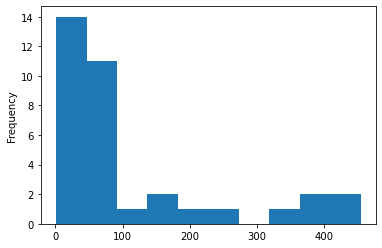

In [15]:
df_clean.loc[df_clean.connection != '500+', 'connection'].astype('int').plot(kind='hist');

We will bin every 50 connections.

In [16]:
# Create bins and labels for increments of 2 minutes
bins = [50 * x for x in range(12)]
labels = ['0-50conn', '51-100conn', '101-150conn', '151-200conn', '201-250conn', 
          '251-300conn', '301-350conn', '351-400conn', '401-450conn', '451-500conn', '500+conn']

# Enumerate '500+' to '501' for binning
df_clean.loc[df_clean.connection == '500+', 'connection'] = 501

# Binning
df_clean['connection_binned'] = pd.cut(df_clean.connection.astype('int'), 
                                       bins=bins, labels=labels, include_lowest=True)

df_clean.connection_binned.value_counts(sort=False)

0-50conn       17
51-100conn      8
101-150conn     1
151-200conn     2
201-250conn     1
251-300conn     1
301-350conn     1
351-400conn     1
401-450conn     2
451-500conn     1
500+conn       18
Name: connection_binned, dtype: int64

Most candidates have few (< 50) or many (> 500) connections. We will come back to this later.

#### Now the main feature, 'job_title'

First, notice that we have a number of acronyms. We will expand these into full expressions, where possible/needed.

In [17]:
# Tokenize 'job_title' so we can look for acronyms
acro_test = df_clean.job_title.apply(nlp)

# Grab all words that are entirely uppercase (i.e., the acronym candidates)
possible_acronyms = []
for r in acro_test:
    pa = [a for a in r if a.is_upper == True]
    possible_acronyms.append(pa)

# Flatten list of possible acronyms
possible_acronyms = [item.text for sublist in possible_acronyms for item in sublist]
' '.join(set(possible_acronyms))

'SPHR ENGIE GIS JTI RRP CSR HR EY C.T. MES HRIS GPHR CHRO EPIK SVP'

In [18]:
# Define the acronyms above, and add a few more that might be generated by data augmentation. 
# In practice, we also could add/import a lengthy list of common job-related acronyms from an external resource.
acro_dict = {'CHRO': 'Chief Human Resources Officer', 'CSR': 'Corporate and Social Responsibility', 
             'GIS': 'Geographic Information System', 'GPHR': 'Global Professional in Human Resources', 
             'HR': 'Human Resources', 'HRIS': 'Human Resources Information System', 
             'MES': 'Manufacturing Execution System', 'SPHR': 'Senior Professional in Human Resources', 
             'SVP': 'Senior Vice President', 'VP': 'Vice President', 
             'CEO': 'Chief Executive Officer', 'CTO': 'Chief Technology Executive', 
             'MBA': 'Master of Business Administration', 'MS': 'Master of Science', 
             'PhD': 'Doctor of Philosophy', 'PHD': 'Doctor of Philosophy',
             'phd': 'doctor of philosophy',  
             'BA': 'Bachelor of Science', 'BS': 'Bachelor of Arts'}

# For replacing acronyms with full text inside of spaCy doc
def acro_expand(doc):
    doc = nlp(doc)
    lst = [t.text if t.text not in acro_dict.keys() else acro_dict[t.text] for t in doc]
    return ' '.join(lst)

Other text cleaning and NLP utilities:

In [19]:
# For expanding contractions
def expand_contraction(doc):
    return contractions.fix(doc)

# For making lowercase and removing puncuation and special characters
punc = "!#$%&()*+,-./:;<=>?@[\\]^_`{|}~'\""
def case_punc(doc):
    doc = doc.lower()
    return (''.join(char if char not in punc else ' ' for char in doc))

# For removing extra whitespace, tab, newline
def remove_extraw_t_n(doc):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', doc).strip()

# Define stopwords (taken from spaCy)
stopw = nlp.Defaults.stop_words

# For convert words (minus the stopwords) to lemma
def word_to_lemma(doc):
    filtered=[]
    for t in nlp(doc):
        if t.is_stop==False:
            filtered.append(t.lemma_)
    return ' '.join(lem for lem in filtered)

# For removing 1-2 letter words not on stopword list (spurious objects from tokenization or data augmentation)
def drop_1_2_char(doc):
    return ' '.join([w for w in doc.split() if len(w)>2])

In [20]:
# Preprocess 

# Remove acronyms
df_clean['job_preprocessed'] = df_clean.job_title.apply(acro_expand)
# Expand contractions (if any)
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(expand_contraction)
# Make lowercase and remove punctuation
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(case_punc)
# Remove extra whitespace, tabs, newlines
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(remove_extraw_t_n)

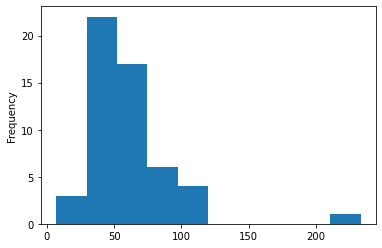

In [21]:
# Check distribution of 'job_preprocessed' lengths
df_clean['job_preprocessed'].apply(len).plot(kind='hist');

Most job titles are distributed together. The 1 really long one contained many acronyms that were expanded, and the shortest 1 is for a student.

In [22]:
maxi = df_clean['job_preprocessed'].apply(len).argmax()
print(df_clean['job_preprocessed'].iloc[maxi])
print()
mini = df_clean['job_preprocessed'].apply(len).argmin()
print(df_clean['job_preprocessed'].iloc[mini])

senior vice president chief human resources officer marketing communications corporate and social responsibility officer engie houston the woodlands energy global professional in human resources senior professional in human resources

student


Now these features are ready to be augmented, but first, we will instantiate our vectorizers.

## Vectorization

We will try 3 different feature sets.
1. Bag of words (BOW) - provided by sklearn
2. TFIDF - provided by sklearn
3. Averge word vectors for each 'job_title' using static word vectors in the loaded spaCy model.

First, BOW and TFIDF:

In [23]:
# We use stopwords from spaCy and make text lowercase
countv = CountVectorizer(stop_words=stopw, lowercase=True)#, ngram_range=(1, 3))
tfidf = TfidfVectorizer(stop_words=stopw, lowercase=True)#, ngram_range=(1, 3))

Third, we use word vectors.

In [24]:
# Define sklearn-compatible transformer
class WordVectorTransformer(TransformerMixin, BaseEstimator):
    # spaCy model
    def __init__(self, model="en_core_web_lg"):
        self.model = model
    # It doesn't actually do anything with fit
    def fit(self, X, y=None):
        return self
    # Transform text data (a list of documents) into average word vector
    def transform(self, X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])
    
# Instantiate and transform data
wordvec_tra = WordVectorTransformer()

## Data Augmentation

We need to augment the dataset in order to tackle this problem. We will do this in 2 ways.

1. Add some examples of 'job_title' (i.e., professional bios) obtained through webscraping - this will roughly double the dataset
2. Generate new data from the doubled dataset using the NLPAUG library - the end result will roughly increase the original dataset twenty-fold.

For the latter, we will generate new examples through 2 subsequent transformations:  
i) contextual word embedding-based *insertion* on 20% of the original text,  
ii) contextual word embedding-based *substitution* on 20% of the augmented text.

We begin with webscraping.

In [25]:
# url with some data
url = ('https://sg.indeed.com/career-advice/career-development/short-professional-bio-examples?aceid=&gclid=CjwKCAjw8sCRBhA6EiwA6_IF4XUAqFhrclK7fgdcjKxUthXjlZNAc1qiUWOR_E_prH1IprNH2C0BBxoCXuIQAvD_BwE')

# Open webpage
page = urlopen(url)

# Read relevant html excerpt from the webpage
html_bytes = page.read()
html = html_bytes.decode('utf-8')
start_index = html.find('Here are 40 two-sentence short professional bio examples to help you write your own:')
end_index = html.find('ordered-list')
examples = html[start_index: end_index]

# List of 40 'job_title' examples found from url excerpt
example_list = re.findall(r'\"value\":\"\\\"(.+?).\\\"\",\"nodeType\"', examples)


# Now grab cities from somewhere...to be added to data later

# url with some data
url2 = ('https://www.infoplease.com/us/cities/top-50-cities-us-population-and-rank')

# Open webpage
page2 = requests.get(url2)

# Parse
soup = BeautifulSoup(page2.text, 'lxml')

# Table info
table = soup.find('table', id='')

# Table column names
headers = []
for i in table.find_all('th'):
    title = i.text
    headers.append(title)

# Write cities to dataframe
cities = pd.DataFrame(columns=headers)
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text for i in row_data]
    length = len(cities)
    cities.loc[length] = row

In [26]:
# Function to anonymize (remove name from beginning of) each example
def anonymize(doc):
    temp = doc.split()
    return ' '.join([w for w in temp[:5] if not w[0].isupper()]) + ' ' + ' '.join([w for w in temp[5:]])

# Create list of examples
examples_to_add = [anonymize(e) for e in example_list]

# Make index different from original dataset and put into dataframe
new_index = list(range(len(df_clean), len(df_clean) + len(examples_to_add)))
examples_df = pd.DataFrame(data=examples_to_add, index=new_index, columns=['job_preprocessed'])

# Preprocess
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(acro_expand)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(expand_contraction)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(case_punc)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(remove_extraw_t_n)

print(f'We are adding these {len(examples_to_add)} examples to our dataset:')
pd.set_option('max_colwidth', 200)
display(examples_df)
pd.reset_option('max_colwidth')

We are adding these 40 examples to our dataset:


,job_preprocessed
53,and recently graduated with an advanced diploma from smith secondary school i m seeking an internship where i can apply my skills in content creation and increase my experience in digital marketing
54,and a recent college graduate with a bachelor s degree in web design i m seeking a full time opportunity where i can employ my programming skills
55,and passionate about writing engaging content for businesses i specialise in topics like technology travel and food
56,and passionate about social justice i m currently working as an assistant for martin law
57,and graduated from state university in may 2020 i m interning as a grant writer and practising research and writing every day
58,and a farmer i m passionate about community supported agriculture and sustainability
59,and manage a small cafe i m passionate about making delicious food for others
60,and seeking a position as an architect i have extensive experience in civil engineering and computer aided design
61,and love helping people start their own businesses i work as a business consultant at rosewood consulting
62,and can help you with all your information technology needs i m certified in cybersecurity and networks


We will create multiple duplicates for 5 of the examples above in order to generate multiple clusters. We intentionally keep index=74 to add to the HR pool of candidates (majority group in our original dataset), but the other 4 will be chosen randomly. Since our original dataset is dominated by 1 theme (HR), our augmentation approach should yield something around 5 clusters in total.

In [27]:
# Array of 4 random rows to duplicate
dups = np.random.randint(53, 92, 4)
# Check if index=74
mask = dups == 74
c = np.count_nonzero(mask)
# Replace 74 with 'not 74'
while c > 0:
    np.where(dups == 74, np.random.randint(53, 92, 1), dups)
    # Recheck if a 74 is present
    mask = dups == 74
    c = np.count_nonzero(mask)

# Add index=74 to get 5 rows to duplicate
dups = np.append(dups, [74])

# Dataframe of rows to duplicate
dups_df = examples_df.loc[dups, :]

# Upsample 19 times (plus original, makes 20x increase of those 5 rows)
dups_df = pd.concat([dups_df]*19)

# Combine with other examples
examples_df_withdups = pd.concat([examples_df, dups_df])

# Now combine original dataset and scraped dataset with duplicates (for augmentation)
df_clean_new_withdups = pd.concat([df_clean, examples_df_withdups])
# Also combine original and scraped datasets without duplicates (to be appended to augmented dataset)
df_clean_new = pd.concat([df_clean, examples_df])

# Set 'id' and 'fit' to zero for scraped data
df_clean_new_withdups['id'].fillna(0, inplace=True)
df_clean_new_withdups['fit'].fillna(0, inplace=True)
df_clean_new['id'].fillna(0, inplace=True)
df_clean_new['fit'].fillna(0, inplace=True)
# Set to integer
df_clean_new['id'] = df_clean_new.id.astype(int)

Now the augmentation.

In [28]:
# Load model for synonyms
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Instantiate character augmenter
# aug_typo = nac.KeyboardAug(aug_char_max=1, aug_word_max=2)

# Instantiate word augmenter via synonym substitution
# aug_syno = naw.SynonymAug(aug_src='wordnet', aug_max=5, aug_p=0.3, stopwords=stopw)

# Instantiate 2 contextual word embedding augmenters via distilled BERT model
aug_bert1 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='insert',
                                      aug_p=0.2, stopwords=stopw, top_k=40)
aug_bert2 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute', 
                                      aug_p=0.2, stopwords=stopw, top_k=40)

# Flow sequence of data augmentation
aug_seq = naf.Sequential([aug_bert1, aug_bert2])

Now, we upsample/augment our dataset.

In [29]:
# Prepare lists for 'id' and augmented data
id_data = []
aug_data = []

# Number of new data samples
n_aug = 9
    
# Data augmentation
for row in tqdm(df_clean_new_withdups.index):
    the_id = int(df_clean_new_withdups.id.iloc[row])
    the_text = df_clean_new_withdups.job_preprocessed.iloc[row]
    aug_list = aug_seq.augment(the_text, n=n_aug, num_thread=4)
    # Keep record of 'id', but distinguish from original data by adding 1000
    id_data.append(the_id + 1000)
    aug_data.append(aug_list)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [08:51<00:00,  2.82s/it]


In [30]:
# Flatten augmented data
flat_list = [item for sublist in aug_data for item in sublist]
# Get indices from aug_data for mapping id_data accordingly (if desired - otherwise disregard)
index_for_id = [ind // n_aug for ind, x in enumerate(flat_list)]
# 'Flatten' indices for augmented data
flat_list_id = [id_data[x] for x in index_for_id]

# Enter augmented data into dataframe
df_aug = pd.DataFrame([item for item in flat_list], columns=['job_augmented'])

# Add 'id' to dataframe
df_aug['id'] = np.asarray(flat_list_id).astype(int)

Now we can generate our 3 datasets (BOW, TFIDF, spaCy vectors) starting with the augmented data.

In [31]:
# Re-preprocess to remove any oddities showing up from BERT 
df_aug['job_preprocessed'] = df_aug.job_augmented.apply(acro_expand)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(case_punc)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(remove_extraw_t_n)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(drop_1_2_char)

# Add a location and random number of connections
df_aug['job_plus'] = [r + f' {cities.iloc[np.random.randint(0, 50), 1]}'
                                   + f' {str(np.random.randint(0, 501))}conn' 
                                   for r in df_aug.job_preprocessed]

# Oh, let's not forget to add 'location' and 'connection' to 'job_title' in df_clean_new!!
df_clean_new['job_plus'] = (df_clean_new.job_preprocessed + ' ' + locations.txt1.str.lower() 
                        + ' ' + locations.txt2.str.lower()
                        + ' ' + df_clean_new.connection_binned.astype(str))
# And fill in NANs
df_clean_new['job_plus'] = np.where(df_clean_new['job_title'].isna(), 
                                    [r + f' {cities.iloc[np.random.randint(0, 50), 1]}'
                                     + f' {str(np.random.randint(0, 501))}conn' 
                                     for r in df_clean_new.job_preprocessed],  
                                    [r for r in df_clean_new.job_plus])

# Final cleanup
df_aug['job_plus'] = df_aug.job_plus.apply(case_punc)
df_aug['job_plus'] = df_aug.job_plus.apply(remove_extraw_t_n)
df_aug['job_plus'] = df_aug.job_plus.apply(drop_1_2_char)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(case_punc)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(remove_extraw_t_n)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(drop_1_2_char)

# Examples
print('Example from df_clean_new:')
display(df_clean_new['job_plus'].iloc[20])
print('Example from df_aug:')
display(df_aug['job_plus'].iloc[20])

# We also will lemmatize the final clean(_new) and augmented text (doesn't affect spaCy vectors, only BOW and TFIDF)
df_clean_new['lemmas'] = df_clean_new.job_plus.apply(word_to_lemma)
df_aug['lemmas'] = df_aug.job_plus.apply(word_to_lemma)

# Save clean and augmented data
df_clean_new.to_csv('original_scraped.csv')
df_aug.to_csv('augmented.csv')

# Add original examples to augmented data and save lemmas
data = pd.concat([df_clean_new.lemmas, df_aug.lemmas]).reset_index(drop=True)
data.to_csv('lemmas_for_X.csv')

# BOW data
X_bow = countv.fit_transform(data)
print('X_bow shape:', X_bow.shape, '\n')

# TFIDF data
X_tfidf = tfidf.fit_transform(data)
print('X_tfidf shape:', X_tfidf.shape, '\n')

# spaCy vector data
X_wv = wordvec_tra.fit_transform(data)
print('X_wv shape:', X_wv.shape)

Example from df_clean_new:


'business management major and aspiring human resources manager monroe louisiana 50conn'

Example from df_aug:


'aspiring human healthcare technicians professional milwaukee wisconsin 446conn'

C:\Users\clarkac\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


X_bow shape: (1785, 3112) 

X_tfidf shape: (1785, 3112) 

X_wv shape: (1785, 300)


## Clustering

Due to the high dimensionality of our datasets, we use PCA to aid in visualizing clusters.  
(Although we could have performed PCA prior to clustering, we chose to do it aftward since much of the data variance was not described by the principal components.)

We will attempt clustering using 4 different algorithms: 
1. K Means - because it's easy to try and simple to interpret when it works
2. Bayesian Gaussian Mixture - because it's more flexible than KMeans by assuming ellipsoidal (vs. spherical) clusters
3. Agglomerative Clustering - because it provides a nice graphic (dendrogram) to interpret and doesn't assume cluster shapes
4. Spectral Clustering - because it also doesn't assume cluster shapes, but rather relies on data connectivity.

#### PCA for forthcoming plots

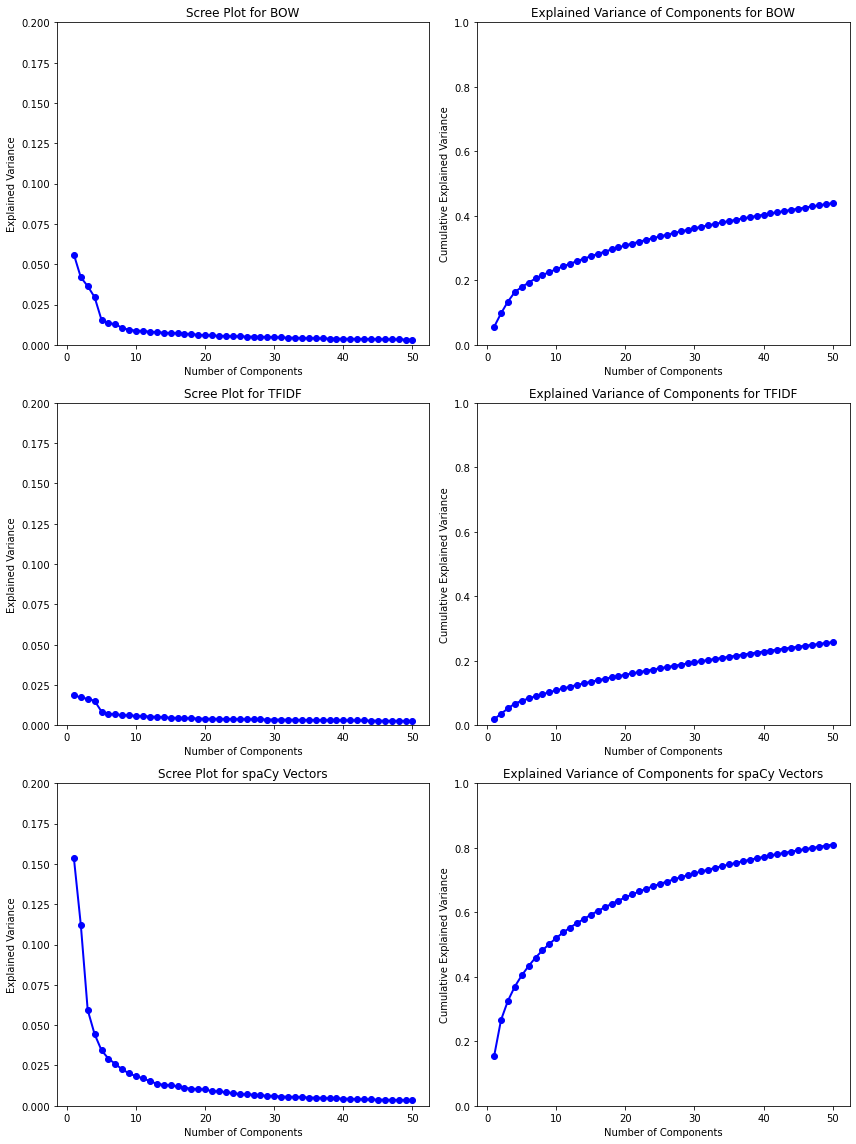

In [32]:
# PCA for BOW, TFIDF, and spaCy vectors to be used for visualization later
pca_bow = PCA(n_components=50, random_state=ranseed)
pca_bow_fit = pca_bow.fit(X_bow.todense())
pca_tfidf = PCA(n_components=50, random_state=ranseed)
pca_tfidf_fit = pca_tfidf.fit(X_tfidf.todense())
pca_wv = PCA(n_components=50, random_state=ranseed)
pca_wv_fit = pca_wv.fit(X_wv)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 16))

PC_values = np.arange(pca_bow_fit.n_components_) + 1
ax1.plot(PC_values, pca_bow_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax1.set_title('Scree Plot for BOW')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance')
ax1.set_ylim(0, 0.2)

ax2.plot(PC_values, pca_bow_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax2.set_title('Explained Variance of Components for BOW')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_ylim(0, 1)

PC_values = np.arange(pca_tfidf_fit.n_components_) + 1
ax3.plot(PC_values, pca_tfidf_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax3.set_title('Scree Plot for TFIDF')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Explained Variance')
ax3.set_ylim(0, 0.2)

ax4.plot(PC_values, pca_tfidf_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax4.set_title('Explained Variance of Components for TFIDF')
ax4.set_xlabel('Number of Components')
ax4.set_ylabel('Cumulative Explained Variance')
ax4.set_ylim(0, 1)

PC_values = np.arange(pca_wv_fit.n_components_) + 1
ax5.plot(PC_values, pca_wv_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax5.set_title('Scree Plot for spaCy Vectors')
ax5.set_xlabel('Number of Components')
ax5.set_ylabel('Explained Variance')
ax5.set_ylim(0, 0.2)

ax6.plot(PC_values, pca_wv_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax6.set_title('Explained Variance of Components for spaCy Vectors')
ax6.set_xlabel('Number of Components')
ax6.set_ylabel('Cumulative Explained Variance')
ax6.set_ylim(0, 1)

plt.tight_layout()
plt.show()

Our BERT augmentation scheme seems to have generated a great deal of variance/noise that cannot be captured by even the first 50 principal components for BOW and TFIDF, but PCA will still serve us well for visualization.

For any given number of components, the variance is most fully explained for the spaCy vector model. This may be due to how data augmentation was carried out (using contextual word embeddings). The word insertions and substitutions will not change the similarities captured by spaCy word vectors as much as the word counts (normalized or not) of BOW and TFIDF vectors.

In [33]:
# Choose number of components based on scree plot
n_co = 4

# Finalize PCA for BOW and spaCy vectors
pca_bow = PCA(n_components=n_co, random_state=ranseed)
scores_pca_bow = pca_bow.fit_transform(X_bow.todense())
pca_tfidf = PCA(n_components=n_co, random_state=ranseed)
scores_pca_tfidf = pca_tfidf.fit_transform(X_tfidf.todense())
pca_wv = PCA(n_components=n_co, random_state=ranseed)
scores_pca_wv = pca_wv.fit_transform(X_wv)

#### Clustering

In [34]:
# Use KMeans to cluster jobs
rg = range(2, 20, 1)
SSE_bow = []
score_bow = []
SSE_tfidf = []
score_tfidf = []
SSE_wv = []
score_wv = []
for cluster in tqdm(rg):
    
    kmeans_bow = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_bow = kmeans_bow.fit(X_bow)
    SSE_bow.append(lab_bow.inertia_)
    score_bow.append(silhouette_score(X_bow, lab_bow.labels_))
    
    kmeans_tfidf = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_tfidf = kmeans_tfidf.fit(X_tfidf)
    SSE_tfidf.append(lab_tfidf.inertia_)
    score_tfidf.append(silhouette_score(X_tfidf, lab_tfidf.labels_))
    
    kmeans_wv = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_wv = kmeans_wv.fit(X_wv)
    SSE_wv.append(lab_wv.inertia_)
    score_wv.append(silhouette_score(X_wv, lab_wv.labels_))
    
# Put data into dataframe
frame = pd.DataFrame({'Cluster': rg, 'SSE_bow': SSE_bow, 'sil_score_bow': score_bow, 
                      'SSE_tfidf': SSE_tfidf, 'sil_score_tfidf': score_tfidf, 
                      'SSE_wv': SSE_wv, 'sil_score_wv': score_wv})

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:59<00:00,  9.99s/it]


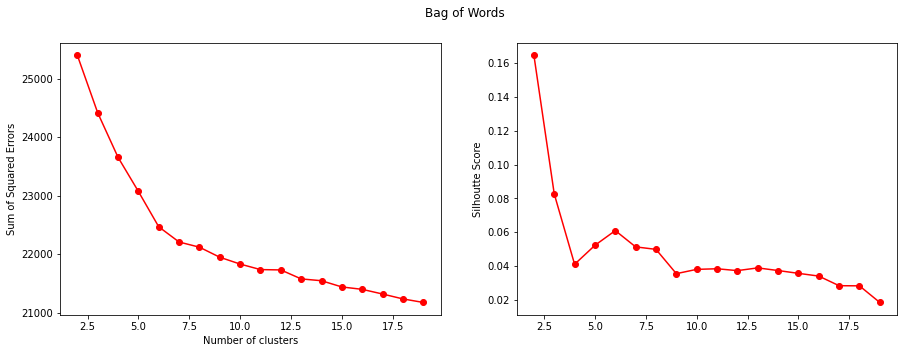

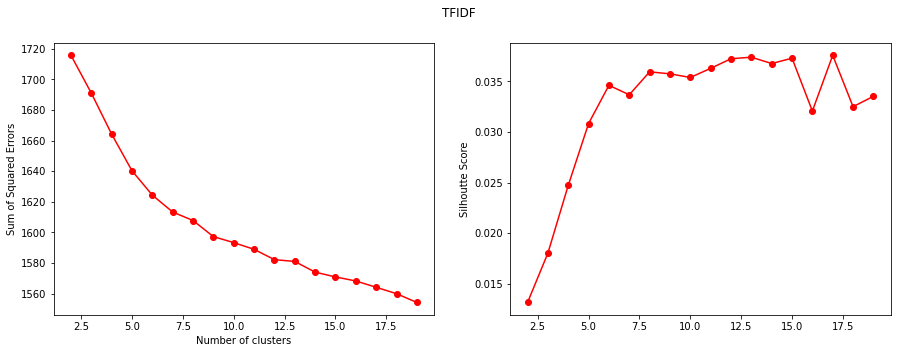

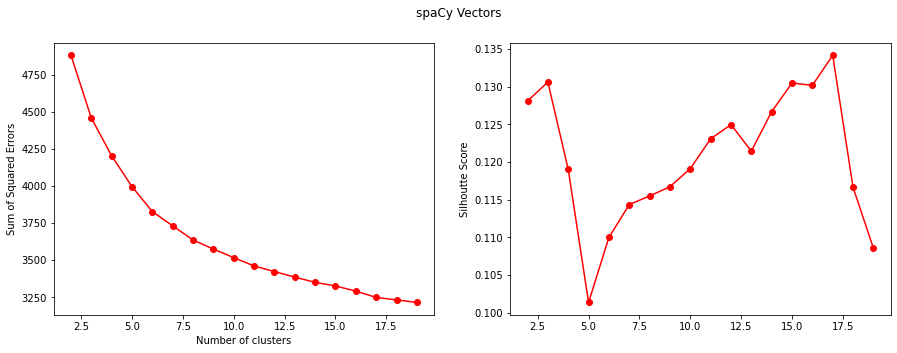

In [35]:
# Plot error and silhoutte score for BOW
fig, ax = plt.subplots(1, 2, figsize=(15, 5), )
ax[0].plot(frame['Cluster'], frame['SSE_bow'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_bow'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('Bag of Words')
plt.show()

# Plot error and silhoutte score for TFIDF
fig, ax = plt.subplots(1, 2, figsize=(15, 5), )
ax[0].plot(frame['Cluster'], frame['SSE_tfidf'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_tfidf'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('TFIDF')
plt.show()

# Plot error and silhoutte score for spaCy vectors
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(frame['Cluster'], frame['SSE_wv'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_wv'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('spaCy Vectors')
plt.show()

The number of clusters based on a combination of elbow method and silhoutte score is 6 for BOW, 6 or greater for TFIDF, and something similar for spaCy vectors (6 or 7).

The silhoutte score magnitude isn't great at all (on a scale of -1 to 1), but the PCA-based plots below reveal clear clusters (note: we got much higher silhoutte scores when *clustering after PCA*).

Below we plot the first 2 principal components versus each other for the 3 encodings.

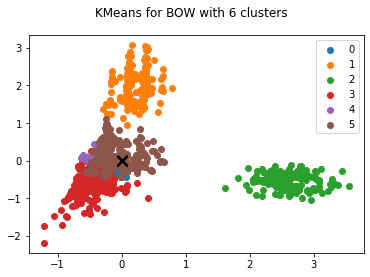

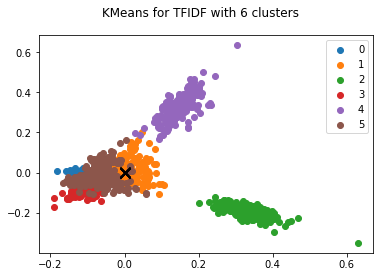

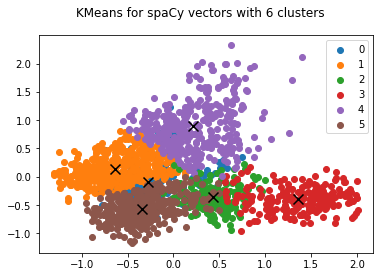

In [43]:
# Number of clusters
n_cl = 6
# Principal components to plot
first = 0
second_or_later = 1

# KM cluster labels for BOW
kmeans_bow = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_bow.fit_predict(X_bow)
centers = np.array(kmeans_bow.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_bow[label == u, first], scores_pca_bow[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for BOW with {n_cl} clusters')
plt.legend()
plt.show()


# Number of clusters
n_cl = 6

# KM cluster labels for TFIDF
kmeans_tfidf = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_tfidf.fit_predict(X_tfidf)
centers = np.array(kmeans_tfidf.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_tfidf[label == u, first], scores_pca_tfidf[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for TFIDF with {n_cl} clusters')
plt.legend()
plt.show()


# Number of clusters
n_cl = 6

# KM cluster labels for spaCy vectors
kmeans_pca_wv = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_pca_wv.fit_predict(scores_pca_wv)
centers = np.array(kmeans_pca_wv.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_wv[label == u, first], scores_pca_wv[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for spaCy vectors with {n_cl} clusters')
plt.legend()
plt.show()

Clusters are better visualized in 3d:

In [42]:
# Number of clusters
n_cl = 6
# Principal components to plot
first = 0
second_or_later = 1
third = 2

# KM cluster labels for BOW
kmeans_bow = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_bow.fit_predict(X_bow)
centers = np.array(kmeans_bow.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_bow[label == u, first], 
                                y=scores_pca_bow[label == u, second_or_later], 
                                z=scores_pca_bow[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='BOW Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
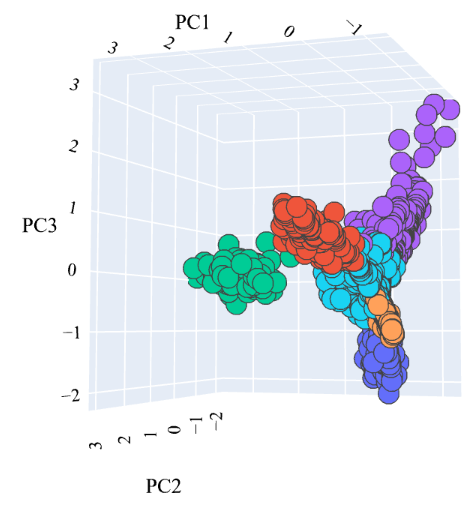

In [44]:
# Number of clusters
n_cl = 6

# KM cluster labels for TFIDF
kmeans_tfidf = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_tfidf.fit_predict(X_tfidf)
centers = np.array(kmeans_tfidf.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_tfidf[label == u, first], 
                                y=scores_pca_tfidf[label == u, second_or_later], 
                                z=scores_pca_tfidf[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='TFIDF Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
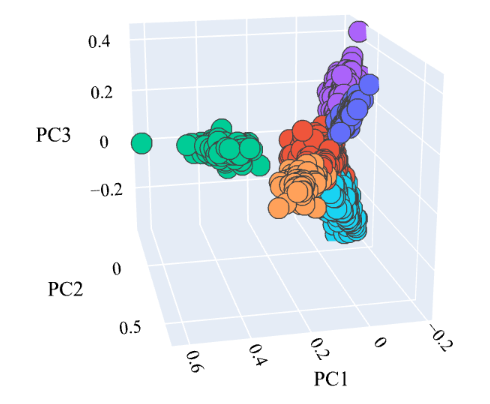

In [45]:
# Number of clusters
n_cl = 6

# KM cluster labels for spaCy vectors
kmeans_wv = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_wv.fit_predict(X_wv)
centers = np.array(kmeans_wv.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_wv[label == u, first], 
                                y=scores_pca_wv[label == u, second_or_later], 
                                z=scores_pca_wv[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='spaCy Vector Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
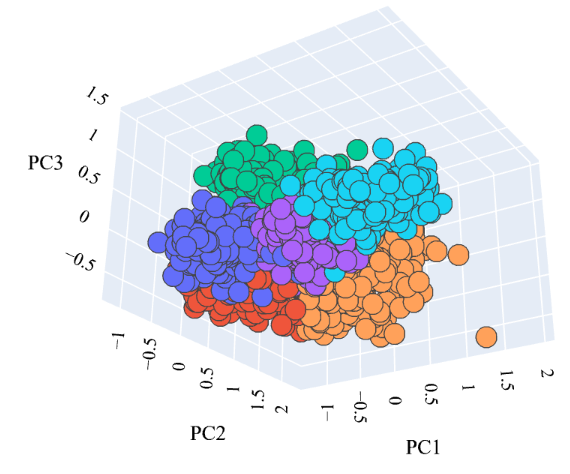

Of these, BOW and TFIDF have similarly distinctive clusters (with n_cl=6). Averaged word vectors give the least spatial separation, although the boundaries are still pretty clear.

For each encoding, let's compare job titles within and across the different clusters, as well as see which cluster KMeans places our keywords.

In [52]:
# Dataframe with preprocessed and lemmatized text
final_data = pd.concat([df_clean_new[['id', 'job_plus']], df_aug[['id', 'job_plus']]]).reset_index(drop=True)

# Assign clusters to texts
final_data['cluster_bow'] = kmeans_bow.fit_predict(X_bow)
final_data['cluster_tfidf'] = kmeans_tfidf.fit_predict(X_tfidf)
final_data['cluster_wv'] = kmeans_wv.fit_predict(X_wv)

In [54]:
# Job examples by cluster for BOW
for c in range(6):
    pd.set_option('max_colwidth', 150)
    print(f'Sample from BOW Cluster {c}:')
    display(final_data.job_plus[final_data.cluster_bow == c].sample(5))
    print()
    pd.reset_option('max_colwidth')

Sample from BOW Cluster 0:


1577    concerned about nature and geological exploration been truck driver where continually gained experiences interesting european places columbus ohio...
1659      passionate about aerospace and space science was also currently chartered truck driver where gained success places charlotte north carolina 273conn
1755    passionate about european travel and exploration being currently truck taxi pilot where successfully gained experiences all geographic settings vi...
821                passionate about travel and exploration while currently truck driver where gained travels overseas years colorado springs colorado 154conn
1396    concerned about travel and exploration currently qualified auto driver where successfully gained hiking notoriety caravan places memphis tennessee...
Name: job_plus, dtype: object


Sample from BOW Cluster 1:


1185    and dedicated government service employee looking successfully apply external relations service administration skills more challenging role san jo...
1010    and food service association employee qualified continually apply superior customer information service skills more challenging role fort worth te...
1454    and customer resources service ltd employee remain looking apply customer nutrition service management skills more challenging experience sacramen...
1636     and food ministry employee currently prepared apply customer service certified credentials more challenging workplace role memphis tennessee 221conn
698     and potential external marketing service employee empowered simultaneously apply customer support systems skills more challenging role san francis...
Name: job_plus, dtype: object


Sample from BOW Cluster 2:


1270    and recently graduated with english certificate from smith mills secondary school seeking internet mba where can apply technical skills internet c...
1178    and recently commenced with advanced diploma from smith comprehensive secondary programme have contemplating seeking internet education where can ...
997     and recently graduated with associate degree from delhi secondary school also considering seeking internship where can apply spare time content do...
573     and most recently graduated with advanced certificate from smith college secondary high school now seeking internship where can apply learning exp...
1760    and most recently she graduated with online advanced business application from william smith high schools pursuing internship where can apply appl...
Name: job_plus, dtype: object


Sample from BOW Cluster 3:


1642                                    human computer systems professional has extensive service work the payroll and administration denver colorado 124conn
1236                 human opportunity resource management specialist has extensive managerial experience recruitment and productivity wichita kansas 174conn
282                                      aspiring human investment manager seeking internship marketing talent opportunities charlotte north carolina 239conn
530     aspiring human resources consultants graduating may continue before seeking entrance certificate level human resources administration position dow...
1109                        human health resource planner has accumulated extensive experience employee governance and administration denver colorado 409conn
Name: job_plus, dtype: object


Sample from BOW Cluster 4:


1249                 kim paints her many portraits for individuals couples and their friends she would invite come find you austin texas 2conn
1387    paints numerous nice portraits for individuals couples and other subjects she would simply prefer please meet you miami florida 84conn
1385          and several whimsical flower portraits for various young couples and places she would wish still paint you omaha nebraska 81conn
1208        paints multiple double portrait portraits for intimate members couples and together she would love paint you houston texas 116conn
1425                              also personal portraits for individuals and friends she would surely love help you fresno california 259conn
Name: job_plus, dtype: object


Sample from BOW Cluster 5:


919    the deputy and creative director for blooming flowers she and been talked about designing beautiful outdoor engaging content oklahoma city oklahom...
655                and can assist you with all your information system technology and involved building ict and intelligence networks wichita kansas 330conn
659         and can please help you with all your data sharing technology networking needs everyone interested cybersecurity and networks washington 102conn
756    the founder and executive deputy executive creative officer garcia alvarez consulting did not shy about helping companies promote san jose califor...
687                                                                 and teach second grade special approach balanced learning bakersfield california 331conn
Name: job_plus, dtype: object

In [55]:
# Job examples by cluster for TFIDF
for c in range(6):
    pd.set_option('max_colwidth', 150)
    print(f'Sample from TFIDF Cluster {c}:')
    display(final_data.job_plus[final_data.cluster_tfidf == c].sample(5))
    print()
    pd.reset_option('max_colwidth')

Sample from TFIDF Cluster 0:


931                          paints provocative portrait poses for wealthy women like them and other families she would invite paint you mesa arizona 108conn
1251                  she paints whimsical pieces for elderly individuals and their families she would particularly love picture you detroit michigan 395conn
1746         paints highly sensitive character descriptions for various individuals couples and particular women she would like help you mesa arizona 479conn
1562    kennedy paints intimate portraits for figures from groups and families she would sincerely endeavour visually identify you minneapolis minnesota 4...
1025                    leigh paints whimsical intimate portraits for famous individuals and sexual partners she would love paint you arlington texas 339conn
Name: job_plus, dtype: object


Sample from TFIDF Cluster 1:


409       masters science geography from eastern victoria polytechnic university christchurch chicago illinois 144conn
617    and lifelong farmer passionate about our human responsibility supported food and tourism omaha nebraska 491conn
483                                                student sydney westfield federal university atlanta georgia 324conn
547                              offering business financial services and analytics risk bakersfield california 94conn
35                              bachelor science biology from victoria university wellington baltimore maryland 50conn
Name: job_plus, dtype: object


Sample from TFIDF Cluster 2:


1086    and recently graduated with internship program from smith hall secondary vocational school seeking internship where can ultimately apply entrepren...
1130    and recently endowed with english diploma from george smith junior comprehensive school seeking international internship where can eventually appl...
1176    and recently achieved with additional advanced diploma from liverpool street secondary school are considering seeking internship where can apply s...
1173    and more recent has graduated with ict technician diploma from smith secondary school having also secured internship where can professionally appl...
1316    and recently graduated with adult advanced education diploma from adam smith secondary school was seeking advanced placement where can further imp...
Name: job_plus, dtype: object


Sample from TFIDF Cluster 3:


1037    most passionate about camping and exploration currently hotel owner where successfully made incredible experiences extreme places omaha nebraska 4...
821                passionate about travel and exploration while currently truck driver where gained travels overseas years colorado springs colorado 154conn
1438           also about travel and skiing currently chartered vehicle driver where seeks knowledge approximately mountain places oakland california 150conn
1349          teaching about desert travel and petroleum exploration currently chartered bus driver where also done accreditation places mesa arizona 496conn
939     passionate about global exploration and exploration now truck show driver where also have gained experiences international places milwaukee wiscon...
Name: job_plus, dtype: object


Sample from TFIDF Cluster 4:


1679    and fellow food service employee are looking gradually change varied bakery service options more technically challenging role seattle washington 4...
703     and food ministry specialist employee looking effectively translate outstanding nutrition service results more challenging environment wichita kan...
1409     and hospitality service services employee looking expand customer catering service skills more economically challenging role las vegas nevada 95conn
1008    and food emergency relief agency were still looking extend unique customer service skills more economically challenging role seattle washington 27...
1370    and catering service industry looking transform specialized meal service skills more technically challenging customer role jacksonville florida 42...
Name: job_plus, dtype: object


Sample from TFIDF Cluster 5:


301                              nortia staffing primarily the human resources payroll for administrative expenditures due 2621 minneapolis minnesota 148conn
1514                                professional human resource and activist has amassed extensive experience payroll and technology fort worth texas 374conn
478                                            seeking human capital improved opportunities open travel and affordable accommodation fort worth texas 265conn
253                                                  director human resources strategy for north america groupe alain philippe virginia beach virginia 85conn
382     human development professional for the sector leader interactive geographic information acquisition system management management san diego califor...
Name: job_plus, dtype: object

In [56]:
# Job examples by cluster for spaCy vectors
for c in range(6):
    pd.set_option('max_colwidth', 150)
    print(f'Sample from spaCy Cluster {c}:')
    display(final_data.job_plus[final_data.cluster_wv == c].sample(5))
    print()
    pd.reset_option('max_colwidth')

Sample from spaCy Cluster 0:


1144     and social security employee looking carefully apply existing customer management skills more emotionally relevant role indianapolis indiana 143conn
1637    and distinguished service pilot looking seriously apply exceptional customer support service delivery skills more effective role seattle washingto...
1497         and certified security service corps employee and attempting leverage customer service expertise more challenging role oakland california 27conn
1093    and senior security service employee prepared apply innovative customer service automation skills more economically diverse position sacramento ca...
1683    and product service manager always trying apply customer service management skills more challenging workplace experience sacramento california 86conn
Name: job_plus, dtype: object


Sample from spaCy Cluster 1:


398                                   former rrp managing portfolio senior executive jti global tobacco company international tulsa oklahoma 71conn
263                 retired army national security guard sniper hiring manager seeking coaching position scouting resources chicago illinois 92conn
1555                                         human rights analyst has done extensive experience providing payroll and expertise mesa arizona 26conn
34                                   information systems specialist and programmer with love for data and organization gaithersburg maryland 50conn
48      aspiring human resources manager graduating may 2020 seeking entry level human resources position louis cape girardeau missouri 101 150conn
Name: job_plus, dtype: object


Sample from spaCy Cluster 2:


585     and 2013 antioch sage graduate graduate with bachelor program focus biomedical application design students seeking full term time opportunity wher...
1040    and recently graduated with advanced diploma from smith hills media school open position where can successfully apply necessary skills content cre...
609     and graduated from external funding may 2020 interning doctor philosophy grant alongside student and student practising scholarly research and wri...
784     web game developer for oswald pro technologies expert oswald programmer and enjoys using his talent efficiently contribute the already launched li...
1623    and recently graduated with mls advanced diploma from joseph jefferson secondary where also seeking academic internship where can apply skills inn...
Name: job_plus, dtype: object


Sample from spaCy Cluster 3:


41                                                             admissions representative community medical center long beach long beach california 50conn
818               passionate about space travel and exploration currently truck operator where has gained citizenship roughly days tulsa oklahoma 123conn
1662       busy about travel and business currently pickup truck driver where gained driving experiences nearly 300 tourist places tucson arizona 221conn
1620               keen about travel and exploration now currently truck engine contractor where had massive success almost places tulsa oklahoma 243conn
1217    passionate about sea travel and exploration has currently solo yacht driver where has gained notoriety almost major places wichita kansas 365conn
Name: job_plus, dtype: object


Sample from spaCy Cluster 4:


413                                                            bachelor science molecular biology from ross graham university canada portland oregon 289conn
35                                                                    bachelor science biology from victoria university wellington baltimore maryland 50conn
892    registered visiting physician county meath hospital been looking become head hospital nurse apply his leadership talents bakersfield california 40...
131                                                                                     academic board full member celal bay university tucson arizona 1conn
212                                                                             organizations seeking human resources opportunities las vegas nevada 130conn
Name: job_plus, dtype: object


Sample from spaCy Cluster 5:


1023        compose highly whimsical wedding cakes for younger couples and guests she would especially love paint beside you atlanta georgia 108conn
937                       paints oil miniature portraits for siblings families and young families she would love entertain you houston texas 260conn
1338    rogers paints occasional landscape portraits for individuals friends and families she would not love easily visit you denver colorado 44conn
1251         she paints whimsical pieces for elderly individuals and their families she would particularly love picture you detroit michigan 395conn
676                                                  and high spirited school lesson and doing about helping teens love read arlington texas 162conn
Name: job_plus, dtype: object

If we had to guess, I'd say keywords belong to cluster 3 for BOW, 5 for TFIDF, and 1 for spaCy.

In [411]:
# Input 
keywords = 'seeking human resources' # aspiring human resources

# Preprocess
keywords = [word_to_lemma(remove_extraw_t_n(case_punc(expand_contraction(acro_expand(keywords)))))]

# Identify cluster based on BOW
kw_bow = countv.transform(keywords)
kw_cluster_b = kmeans_bow.predict(kw_bow)
print(f'BOW cluster: {kw_cluster_b[0]}, which contains '
      f'{len(final_data[final_data.cluster_bow == kw_cluster_b[0]])} candidates.')

# Identify cluster based on TFIDF
kw_tfidf = tfidf.transform(keywords)
kw_cluster_t = kmeans_tfidf.predict(kw_tfidf)
print(f'TFIDF cluster: {kw_cluster_t[0]}, which contains '
      f'{len(final_data[final_data.cluster_tfidf == kw_cluster_t[0]])} candidates.')

# Identify cluster based on spaCy vectors
kw_wv = wordvec_tra.transform(keywords)
kw_cluster_w = kmeans_wv.predict(kw_wv)
print(f'spaCy cluster: {kw_cluster_w[0]}, which contains '
      f'{len(final_data[final_data.cluster_wv == kw_cluster_w[0]])} candidates.')

BOW cluster: 3, which contains 437 candidates.
TFIDF cluster: 5, which contains 477 candidates.
spaCy cluster: 1, which contains 455 candidates.


Yes! And the cluster size is similar for each dataset. That is reassuring.

Okay, let's quickly check some of the other clustering algorithms (I won't plot up everything - for brevity).

In [61]:
# Try BayesianGaussianMixture in place of KMeans

# Use a larger number of clusters and allow weights to be reduced to small values for excess clusters.
n_cl = 8

BGM_bow = BayesianGaussianMixture(n_components=n_cl, random_state=ranseed).fit(X_bow.todense())
print(f'Weights for BOW with {n_cl} clusters: {np.round(BGM_bow.weights_, 3)}')

BGM_tfidf = BayesianGaussianMixture(n_components=n_cl, random_state=ranseed).fit(X_tfidf.todense())
print(f'Weights for TFIDF with {n_cl} clusters: {np.round(BGM_tfidf.weights_, 3)}')

BGM_wv = BayesianGaussianMixture(n_components=n_cl, random_state=ranseed).fit(X_wv)
print(f'Weights for spaCy with {n_cl} clusters: {np.round(BGM_wv.weights_, 3)}')

# Cluster labels
BGM_bow_pred = BGM_bow.predict(X_bow.todense())
BGM_tfidf_pred = BGM_tfidf.predict(X_tfidf.todense())
BGM_wv_pred = BGM_wv.predict(X_wv)

Weights for BOW with 8 clusters: [0.043 0.104 0.04  0.062 0.403 0.186 0.059 0.103]
Weights for TFIDF with 8 clusters: [0.096 0.42  0.027 0.098 0.099 0.142 0.1   0.017]
Weights for spaCy with 8 clusters: [0.11  0.144 0.146 0.116 0.071 0.165 0.121 0.126]


Based on the largest weights, BOW has 4 prominent clusters, TFIDF has around 6, and spaCy is less discriminitive with 7 or 8. 

We won't go through all the visualizations here, but I want to note that KMeans looks much more convincing than BGM for the BOW and TFIDF datasets, but comparable for the spaCy vectors. So, KMeans is still preferred.

Let's investigate the dendrogram for hierarchical clustering.

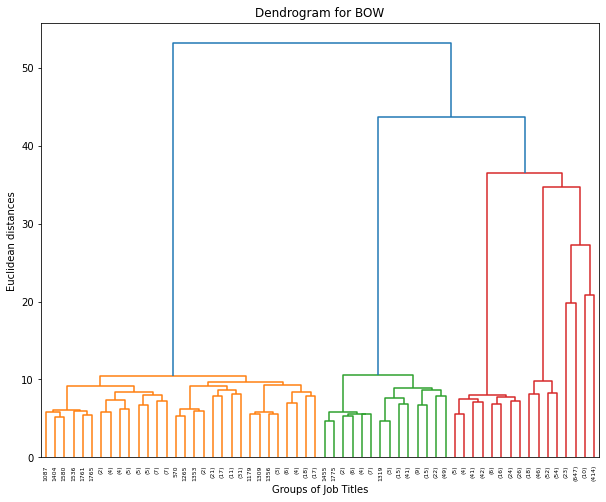

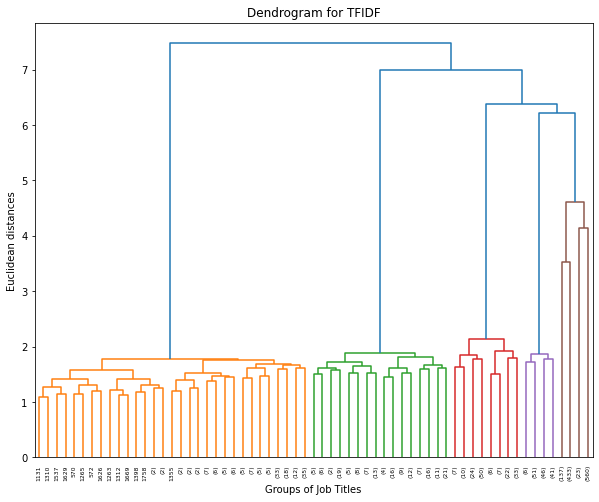

In [69]:
# Linkage matrix for AgglomerativeClustering - BOW
Z_bow = sch.linkage(X_bow.todense(), method='ward')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_bow, p=5, truncate_mode='level')
plt.title('Dendrogram for BOW')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

# Linkage matrix for AgglomerativeClustering - TFIDF
Z_tfidf = sch.linkage(X_tfidf.todense(), method='ward')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_tfidf, p=5, truncate_mode='level')
plt.title('Dendrogram for TFIDF')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

It looks like there are 5-8 clusters for BOW and TFIDF.

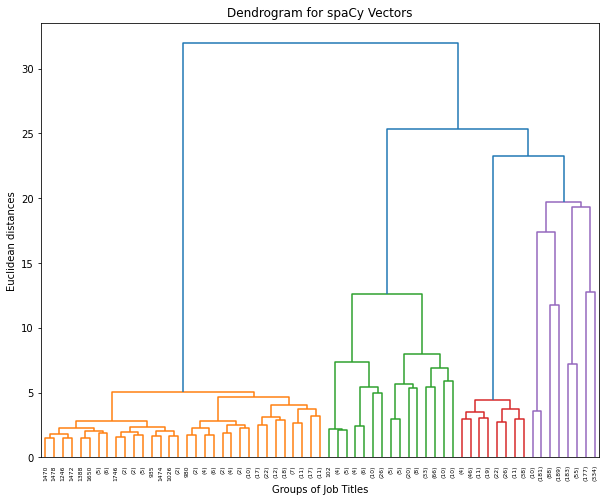

In [70]:
# Linkage matrix for AgglomerativeClustering - spaCy
Z_wv = sch.linkage(X_wv, method='ward')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_wv, p=5, truncate_mode='level')
plt.title('Dendrogram for spaCy Vectors')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

For spaCy vectors, there are ~7 clusters. However, there is a question on which metric to use here.

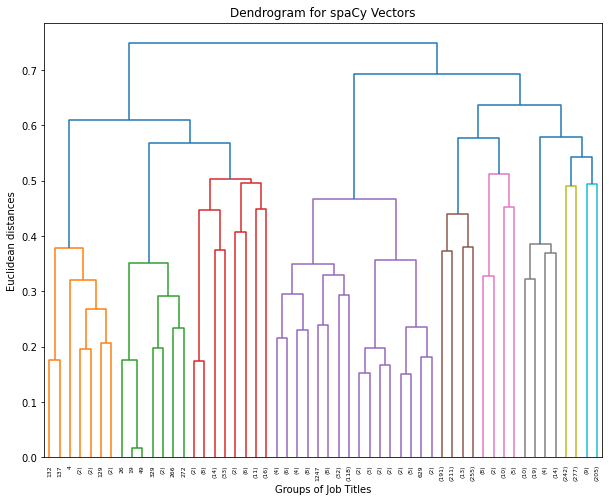

In [78]:
# Linkage matrix for AgglomerativeClustering - spaCy
Z_wv = sch.linkage(X_wv, method='complete', metric='cosine')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_wv, p=5, truncate_mode='level')
plt.title('Dendrogram for spaCy Vectors')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

In the case of cosine distances (often used for similarity of word vectors), the cluster number might be best set to 5 or 8.

Again, for brevity we will skip the visualizations, but I will note that KMeans was superior for each encoding.

In [84]:
# Spectral Clustering
n_cl = 6
SC_bow = SpectralClustering(n_clusters=n_cl, random_state=ranseed).fit(X_bow)
SC_tfidf = SpectralClustering(n_clusters=n_cl, random_state=ranseed).fit(X_tfidf)
SC_wv = SpectralClustering(n_clusters=n_cl, random_state=ranseed).fit(X_wv)

Spectral clustering yielded vastly inferior results (not visualized here) to KMeans for BOW and spaCy vectors, and yet was comparable for TFIDF.

In the end, we will choose KMeans with 6 clusters. We will focus on the TFIDF and spaCy vector datasets for this problem.

In [88]:
# Final KM cluster labels
n_cl = 6
kmeans_bow = KMeans(n_clusters=n_cl, random_state=ranseed)
label_bow = kmeans_bow.fit_predict(X_bow)
centers_bow = np.array(kmeans_bow.cluster_centers_)
kmeans_tfidf = KMeans(n_clusters=n_cl, random_state=ranseed)
label_tfidf = kmeans_tfidf.fit_predict(X_tfidf)
centers_tfidf = np.array(kmeans_tfidf.cluster_centers_)
kmeans_wv = KMeans(n_clusters=n_cl, random_state=ranseed)
label_wv = kmeans_wv.fit_predict(X_wv)
centers_wv = np.array(kmeans_wv.cluster_centers_)

# Final dataframe with preprocessed and lemmatized text, containing cluster labels
final_data = pd.concat([df_clean_new[['id', 'job_plus']], df_aug[['id', 'job_plus']]]).reset_index(drop=True)
final_data['cluster_bow'] = label_bow
final_data['cluster_tfidf'] = label_tfidf
final_data['cluster_wv'] = label_wv

Before moving on, let's define a function to get nearest neighbors for any point within a cluster (which we will use for rankings).

The nice part about clustering is that it cuts down on the volume of data that the NN function below operates on. If time becomes an issue, approximate NN calculates or additional cluster (subclusters within a cluster) could be necessary.

In [122]:
# All NN for all clusters in the TFIDF and spaCy vectors datasets
n_cl = 6
neigh_tfidf = []
neigh_wv = []
for c in tqdm(range(n_cl)):
    
    # TFIDF (metric is Euclidean distance)
    c_data = final_data.loc[final_data.cluster_tfidf == c, :].reset_index(drop=True)
    X_c = X_tfidf[final_data.cluster_tfidf == c] 
    neigh = NearestNeighbors(n_neighbors=X_c.shape[0]).fit(X_c)
    neigh_tfidf.append(neigh)
    
    # spaCy vectors (metric is cosine similarity)
    c_data = final_data.loc[final_data.cluster_wv == c, :].reset_index(drop=True)
    X_c = X_wv[final_data.cluster_wv == c] 
    neigh = NearestNeighbors(n_neighbors=X_c.shape[0], algorithm='brute', metric='cosine').fit(X_c)
    neigh_wv.append(neigh)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 400.21it/s]


In [450]:
# Let's do better for spaCy vectors

# Fast cosine similarity calculator
# (https://towardsdatascience.com/how-to-build-a-fast-most-similar-words-method-in-spacy-32ed104fe498)
@jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu != 0 and vv != 0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

# For locating nearest neighbors among spaCy vectors
def get_similarity(train, test_row, num_neighbors):
    
    # Neighbor counter
    num_neighbors_count = 0 
    
    distances = []
    for train_row in train:
        
        # Compute distance
        dist = cosine_similarity_numba(test_row, train_row)
        
        # Append tuple of vector, index, and distance
        distances.append((train_row, num_neighbors_count, dist))
        
        # Update index
        num_neighbors_count += 1
        
    # Sort distances (and train_row, num_neighbors_count) by distance
    distances.sort(key=lambda tup: tup[2], reverse=True)

    neighs = []
    for num in range(num_neighbors):
        neighs.append(distances[num][1:])
    return neighs

# Don't really need to save NN using the code below...
# n_cl = 6
# neigh_wv_custom = []
# cluster_lengths = []
# for c in range(n_cl):
    
#     # spaCy vectors (metric is cosine similarity)
#     c_data = final_data.loc[final_data.cluster_wv == c, :].reset_index(drop=True).job_plus
#     X_c = X_wv[final_data.cluster_wv == c]
    
#     # Cluster size
#     length = len(X_c)
#     cluster_lengths.append(length)
    
#     # Loop through all points in cluster
#     for p in tqdm(range(length)):
#         vals = get_similarity(X_c, X_c[p], length)
#         neigh_wv_custom.append(np.array(vals))
        
# # Slice up the long list
# neigh_wv0 = neigh_wv_custom[:cluster_lengths[0]]
# neigh_wv1 = neigh_wv_custom[cluster_lengths[0]: np.sum(cluster_lengths[:2])]
# neigh_wv2 = neigh_wv_custom[np.sum(cluster_lengths[:2]): np.sum(cluster_lengths[:3])]
# neigh_wv3 = neigh_wv_custom[np.sum(cluster_lengths[:3]): np.sum(cluster_lengths[:4])]
# neigh_wv4 = neigh_wv_custom[np.sum(cluster_lengths[:4]): np.sum(cluster_lengths[:5])]
# neigh_wv5 = neigh_wv_custom[np.sum(cluster_lengths[:5]):]

# # Rewrite the list
# neigh_wv_all = [neigh_wv0, neigh_wv1, neigh_wv2, neigh_wv3, neigh_wv4, neigh_wv5]

100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 1461.03it/s]


## Candidate Rankings for Keywords

Initial sampling and ranking.

In [432]:
# Input 
keywords = 'seeking human resources' # aspiring human resources
keywords_processed = word_to_lemma(remove_extraw_t_n(case_punc(expand_contraction(acro_expand(keywords)))))

# Preprocess
keywords_list = [keywords_processed]

# Identify cluster based on TFIDF or spaCy vectors
kw_tfidf = tfidf.transform(keywords_list)
kw_cluster_t = kmeans_tfidf.predict(kw_tfidf)
kw_wv = wordvec_tra.transform(keywords_list)
kw_cluster_w = kmeans_wv.predict(kw_wv)

# Data from cluster
# (reset df index to avoid indexing issues between it and numpy array)
cluster_data_t = final_data.loc[final_data.cluster_tfidf == kw_cluster_t[0], :].reset_index(drop=True)
X_cl_tfidf = X_tfidf[final_data.cluster_tfidf == kw_cluster_t[0]]
cluster_data_w = final_data.loc[final_data.cluster_wv == kw_cluster_w[0], :].reset_index(drop=True)
X_cl_wv = X_wv[final_data.cluster_wv == kw_cluster_w[0]]

In [433]:
# Sampling from cluster data
num_to_review = 10

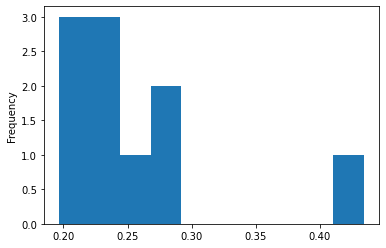

In [405]:
# Get nearest neighbors within TFIDF cluster
d_t = neigh_tfidf[kw_cluster_t[0]].kneighbors(X_cl_tfidf, n_neighbors=num_to_review)[0][0]
i_t = neigh_tfidf[kw_cluster_t[0]].kneighbors(X_cl_tfidf, n_neighbors=num_to_review)[1][0]
cluster_sample_t = cluster_data_t.iloc[list(i_t), :2].copy()

# For computing 'fit' probability
def prob_fun(x, avg, std):
    # Probability of normal distribution
    return norm.pdf(x, loc=avg, scale=std)

# Get 'fit' from distances around keyword:
# we assume mean of distribution is zero (distance from keyword), 
# and standard deviation is on the order of the mean of NN distances
# (This formulation isn't too robust (as opposed to simply using distance)
# but the goal for the project is to have 'fit' fall between 0 and 1.)
cluster_sample_t['fit'] = prob_fun(d_t, 0, np.mean(d_t))

# For recording results for each ranking iteration
iterations_t = cluster_sample_t.to_numpy()

# Histogram of rankings
cluster_sample_t.fit.plot(kind='hist');

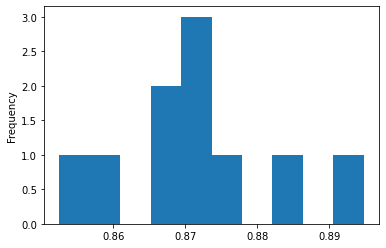

In [451]:
# Get nearest neighbors within spaCy cluster according to cosine similarity
ids = get_similarity(X_cl_wv, kw_wv[0], num_to_review)
i_w = np.array(ids).T[0]
d_w = np.array(ids).T[1]

cluster_sample_w = cluster_data_w.iloc[list(i_w), :2].copy()

# Get 'fit' from cosine distances around keyword
# (This naturally matches our goal to have 'fit' between 0 and 1.)
cluster_sample_w['fit'] = d_w

# For recording results for each ranking iteration
iterations_w = cluster_sample_w.to_numpy()

# Histogram of rankings
cluster_sample_w.fit.plot(kind='hist');

## Manual Review and Re-ranking

,job_plus,fit
0,2019 bauer college business graduate magna cum laude and aspiring human resources professional houston texas 100conn,0.434194
40,2019 robert bauer college business graduate bachelor magna cum sum laude and masters aspiring mba human future professional austin texas 108conn,0.274352
36,bauer college employment administration graduate magna cum laude and leading aspiring human resources professional seattle washington 13conn,0.271740
39,january 2019 bauer institute marketing business graduate magna cum laude and digital marketing human resources consulting professional detroit michigan 22conn,0.260417
37,charles bauer junior college hospitality business graduate magna degree cum laude and aspiring financial resources technician wichita kansas 183conn,0.240955
35,2019 awarded bauer college business degree graduate designation gram laude and graduate aspiring human achievement professional tucson arizona 376conn,0.231455
34,bauer college finance masters student magna cum minor and aspiring human resources professional professional long beach california 314conn,0.226588
38,inducted honorable arnold bauer iii college law graduate magna cum major and advanced human resources marketing professional austin texas 159conn,0.209218
29,aspiring human resources professional kokomo indiana 100conn,0.199006
10,experienced retail manager and aspiring human resources professional austin texas 100conn,0.196916


Enter the index number of the best candidate: 29


,job_plus,fit
29,aspiring human resources professional kokomo indiana 100conn,0.338531
10,experienced retail manager and aspiring human resources professional austin texas 100conn,0.231368
3,student humber college and aspiring human resources generalist canada 100conn,0.216280
0,2019 bauer college business graduate magna cum laude and aspiring human resources professional houston texas 100conn,0.210684
227,aspiring workforce human potential resources professional energetic and community oriented leader indianapolis indiana 321conn,0.200538
57,aspiring junior human resources specialist indianapolis indiana 408conn,0.199424
264,aspiring human resources managers professional chicago illinois 114conn,0.198618
1,aspiring human resources professional durham north carolina 50conn,0.197914
46,aspiring qualified human resources professional jacksonville florida 122conn,0.196963
163,corporate management major and currently aspiring human resources resources professional jacksonville florida 385conn,0.196036


Enter the index number of the best candidate: 227


,job_plus,fit
227,aspiring workforce human potential resources professional energetic and community oriented leader indianapolis indiana 321conn,0.331059
23,aspiring human resources professional energetic and team focused leader austin texas 151 200conn,0.206545
220,2009 professional human resource professional energetic and team focused leader bakersfield california 270conn,0.204782
460,global human capital resource oriented firm has extensive backgrounds government and administration indianapolis indiana 22conn,0.203923
29,aspiring human resources professional kokomo indiana 100conn,0.200646
221,aspiring global human rights energetic and innovative team focused leader washington 72conn,0.199876
57,aspiring junior human resources specialist indianapolis indiana 408conn,0.198985
228,aspiring junior human rights technician professional energetic and politically focused leader colorado springs colorado 117conn,0.197858
224,distinguished lifelong human resources professional accomplished energetic and professionally focused leader arlington texas 61conn,0.197584
222,aspiring mental resources skills became extremely energetic and team inspiring leader raleigh north carolina 401conn,0.196974


Enter the index number of the best candidate: 227
Distributions of nearest neighbors:


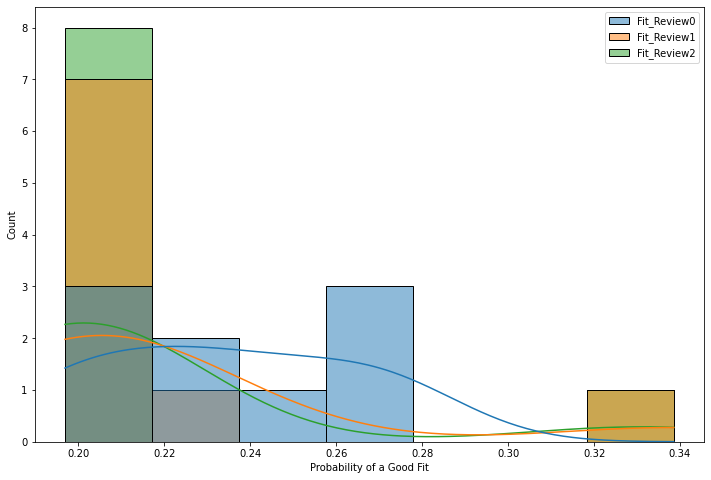

In [406]:
# Display results
pd.set_option('max_colwidth', 200)
display(cluster_sample_t.iloc[:, 1:])

# Initialize and loop counter
top_choice = cluster_sample_t.index[0]
loop = 0

# Initialize manual review
man_review = True
while man_review:
    
    # Manual review
    inp = input('Enter the index number of the best candidate: ')
         
    # Manual review loop stops when best candidate is at top of list
    if int(inp) == top_choice and loop != 0:
        break       
    
    else:
        
        inpu = int(inp)
        
        # Get nearest neighbors
        d_t = neigh_tfidf[kw_cluster_t[0]].kneighbors(X_cl_tfidf[inpu], n_neighbors=num_to_review)[0][0]
        i_t = neigh_tfidf[kw_cluster_t[0]].kneighbors(X_cl_tfidf[inpu], n_neighbors=num_to_review)[1][0]
        
        # Enter rows into dataframe using NN indices
        cluster_sample_t = cluster_data_t.iloc[list(i_t), :2].copy()

        # Compute and enter rankings into dataframe using NN distances from starred candidate
        cluster_sample_t['fit'] = prob_fun(d_t, d_t[0], np.mean(d_t[1:]))

        # Append new top num_to_review to record iteration
        if iterations_t.ndim == 2:
            iterations_t = np.stack((iterations_t, cluster_sample_t.sort_values(by='fit').to_numpy()), axis=-1)
        else:
            iterations_t = np.concatenate((iterations_t, 
                                         cluster_sample_t.sort_values(by='fit').to_numpy()
                                         .reshape((num_to_review, 3, 1))), axis=-1)
            
        # Update top choice and loop counter for next iteration
        top_choice = cluster_sample_t.index[0]
        loop += 1
        
        # Display new top num_to_review
        display(cluster_sample_t.iloc[:, 1:])
        
pd.reset_option('max_colwidth')

# Write history of 'fit' into dataframe
search_history_t = pd.DataFrame(iterations_t[:,-1], dtype='float')
search_history_t.columns = [f'Fit_Review{c}' for c in search_history_t.columns]

# Plot histograms from history for neighbors around ideal candidate
print('Distributions of nearest neighbors:')
plt.figure(figsize = (12,8))
g = sns.histplot(search_history_t.iloc[1:, :], kde=True)
g.set(xlabel='Probability of a Good Fit')
plt.show()

Above we see that there was an initial concentration (blue) around the keywords, where many candidates had a similar probability of being the best fit.

After starring a candidate the distribution separates, giving one individual more likelihood of a good fit over the others.

However, there is some arbitrariness around how we calculate 'fit'. Below we use spaCy vectors, which provide a clear metric of cosine similarity.

,job_plus,fit
1,seeking human resources human resources information system and generalist positions philadelphia 500 conn,0.894783
44,seeking human resources human opportunity strategic information system and its political positions memphis tennessee 225conn,0.885170
8,aspiring human resources manager seeking internship human resources houston texas 50conn,0.874237
42,seeking human resources human resources information retrieval modeling system and generalist positions omaha nebraska 487conn,0.872825
37,assistants seeking human resources development human resources skills development system and generalist positions dallas texas 238conn,0.871291
107,chartered professional human human activity manager seeking internship human resources austin texas 276conn,0.869489
200,seeking greater human resource resources opportunities related travel and information sacramento california 457conn,0.867747
39,seeking credible human resources human services information system and providing policy support positions columbus ohio 47conn,0.865461
103,professional human resource development manager seeking internship vocational human resources houston texas 95conn,0.860104
40,focusing improving strategic resources human resources information system and opposing generalist positions oklahoma city oklahoma 426conn,0.852555


Enter the index number of the best candidate: 8


,job_plus,fit
8,aspiring human resources manager seeking internship human resources houston texas 50conn,1.000000
103,professional human resource development manager seeking internship vocational human resources houston texas 95conn,0.961922
107,chartered professional human human activity manager seeking internship human resources austin texas 276conn,0.949030
3,aspiring human resources management student seeking internship houston texas 500 conn,0.937722
104,top aspiring human resources manager holding additional qualifications human sciences san antonio texas 410conn,0.934398
93,business management aspiring and aspiring human human activities manager dallas texas 179conn,0.925866
108,aspiring human resources academy candidates seeking employment human development programs philadelphia pennsylvania 39conn,0.924308
37,assistants seeking human resources development human resources skills development system and generalist positions dallas texas 238conn,0.922215
102,best practice human resource manager students earn internship human resources kansas city missouri 93conn,0.919326
205,staff seeking human resources position atlanta georgia 286conn,0.917392


Enter the index number of the best candidate: 3


,job_plus,fit
3,aspiring human resources management student seeking internship houston texas 500 conn,1.000000
8,aspiring human resources manager seeking internship human resources houston texas 50conn,0.937722
106,aspiring undergraduate career resources officers usually seeking internship human resources fresno california 419conn,0.912202
103,professional human resource development manager seeking internship vocational human resources houston texas 95conn,0.905146
104,top aspiring human resources manager holding additional qualifications human sciences san antonio texas 410conn,0.902382
60,aspiring mba human and resources management student requires additional albuquerque 150conn,0.902026
56,aspiring senior human resources assistant management personnel seeking internship oklahoma city oklahoma 299conn,0.894918
102,best practice human resource manager students earn internship human resources kansas city missouri 93conn,0.892993
59,currently aspiring employment resources professionals student seeking additional internship fresno california 160conn,0.890578
214,aspiring human resources consultants graduating may continue before seeking entrance certificate level human resources administration position downtown george memphis tennessee 354conn,0.889613


Enter the index number of the best candidate: 3
Distributions of nearest neighbors:


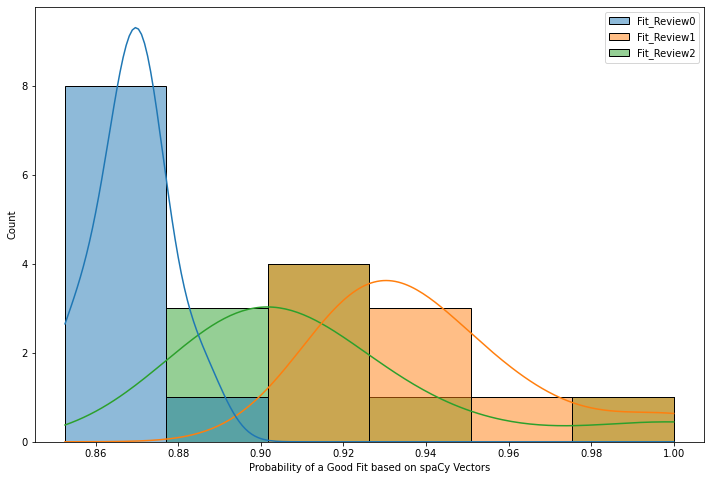

In [452]:
# Display results
pd.set_option('max_colwidth', 200)
display(cluster_sample_w.iloc[:, 1:])

# Initialize and loop counter
top_choice = cluster_sample_w.index[0]
loop = 0

# Initialize manual review
man_review = True
while man_review:
    
    # Manual review
    inp = input('Enter the index number of the best candidate: ')
         
    # Manual review loop stops when best candidate is at top of list
    if int(inp) == top_choice and loop != 0:
        break       
    
    else:
        
        inpu = int(inp)
        
        # Get nearest neighbors
        ids = get_similarity(X_cl_wv, X_cl_wv[inpu], num_to_review)
        i_w = np.array(ids).T[0]
        d_w = np.array(ids).T[1]
        
        # Enter rows into dataframe using NN indices
        cluster_sample_w = cluster_data_w.iloc[list(i_w), :2].copy()

        # Rankings based on similarity to starred candidate
        cluster_sample_w['fit'] = d_w

        # Append new top num_to_review to record iteration
        if iterations_w.ndim == 2:
            iterations_w = np.stack((iterations_w, cluster_sample_w.sort_values(by='fit').to_numpy()), axis=-1)
        else:
            iterations_w = np.concatenate((iterations_w, 
                                         cluster_sample_w.sort_values(by='fit').to_numpy()
                                         .reshape((num_to_review, 3, 1))), axis=-1)
            
        # Update top choice and loop counter for next iteration
        top_choice = cluster_sample_w.index[0]
        loop += 1
        
        # Display new top num_to_review
        display(cluster_sample_w.iloc[:, 1:])
        
pd.reset_option('max_colwidth')

# Write history of 'fit' into dataframe
search_history_w = pd.DataFrame(iterations_w[:,-1], dtype='float')
search_history_w.columns = [f'Fit_Review{c}' for c in search_history_w.columns]

# Plot histograms from history for neighbors around ideal candidate
print('Distributions of nearest neighbors:')
plt.figure(figsize = (12,8))
g = sns.histplot(search_history_w.iloc[1:, :], kde=True)
g.set(xlabel='Probability of a Good Fit based on spaCy Vectors')
plt.show()

Above we see again that there was an initial concentration (blue) around the keywords, where many candidates had a similar probability of being the best fit.

After starring a candidate the distribution separates, giving one individual more likelihood of a good fit over the others. However, now that our metric is standard across all examples, we get a more realistic re-ranking of the non-ideal candidates.

## Conclusion

We used KMeans clustering to segregate data into 6 clusters based on average spaCy word vectors for (augmented) texts concatenated from job title, location, and connnections.

Once the dataset was organized using this unsupervised approach, we implemented a search algorithm based on nearest neighbors.
1. The query is initiated with potential candidates in the cluster that are nearest neighbors to the keywords;
2. Candidates are ranked based on cosine similarity to the keywords vector;
3. Iterative manual review chooses the best candidate from the top ranked ones;
4. New top candidates are generated on each iteration in the manner above;
5. The search ends when the candidate chosen during manual review is already at the top of the rankings;
6. A summary of rankings is plotted at the very end to reveal how tightly spaced the top candidates are around the best fit (narrow for similarly-qualified candidates, broad for few good candidates).

The final script is given below that re-ranks the entire cluster.

Input keywords: computer programmer with web design skills


,job_plus,fit
102,highly also skilled graphic designer and software designed over 100 logos and consulted over five marketing concept videos albuquerque 284conn,0.838214
81,web game developer for oswald technologies currently considers extremely capable programmer and enjoys using his software skills efficiently cater the exciting work internet computing tech louisvi...,0.829134
77,former web applications developer for oswald software technologies and expert programmer and enjoys using his insights contribute the exciting future work ios games company boston massachusetts 19...,0.825053
76,web developer for oswald computer technologies the extremely accomplished programmer and and enjoys using his knowledge witness the very exciting digital work oswald tech washington 35conn,0.823053
24,and 2015 columbia college graduate with microsoft affiliate design thesis focusing web design presently seeking full time opportunity where can employ java programming programming skills denver co...,0.820430
78,freelance web writer for oswald technologies accomplished programmer and enjoys using his professional skills listen the and often upcoming editions his software creations los angeles california 4...,0.805192
101,very highly highly skilled graphic design software created iconic pictures and has worked over five marketing assignments tucson arizona 287conn,0.804674
100,reportedly exceptionally skilled graphic web editing software has designed six major advertisements and worked over five advertising campaigns albuquerque 187conn,0.803285
84,web applications developer for silicon forge technologies and extraordinary accomplished programmer and recently using his online skills contribute the exciting work forge tech san francisco calif...,0.796899
106,software programming manager skilled moving project from concept another reality chicago illinois 21conn,0.791818


Enter the index number of the best candidate: 84


,job_plus,fit
84,web applications developer for silicon forge technologies and extraordinary accomplished programmer and recently using his online skills contribute the exciting work forge tech san francisco calif...,1.000000
77,former web applications developer for oswald software technologies and expert programmer and enjoys using his insights contribute the exciting future work ios games company boston massachusetts 19...,0.915323
83,web game developer for oswald pro technologies expert oswald programmer and enjoys using his talent efficiently contribute the already launched life genius tech san jose california 413conn,0.910681
6,web developer for oswald technologies accomplished programmer and enjoys using his skills contribute the exciting work oswald tech mesa arizona 185conn,0.909016
81,web game developer for oswald technologies currently considers extremely capable programmer and enjoys using his software skills efficiently cater the exciting work internet computing tech louisvi...,0.908263
199,and recently graduated with architectural design from smith chemical technology academy still undertaking internship where can simultaneously apply skills interactive content web creation and shar...,0.904803
272,and have recently advanced with advanced diploma from william smith valley secondary school presently creating institute where can someday test skills creating web applications and increase experi...,0.902960
76,web developer for oswald computer technologies the extremely accomplished programmer and and enjoys using his knowledge witness the very exciting digital work oswald tech washington 35conn,0.893928
80,prolific web developer for atari since apple programmer and still using his talents personally contribute the visually exciting market oswald hardware tech fresno california 79conn,0.888787
140,and recently graduated with honorary advanced doctorate from smith secondary where seeking internship where can improve creative skills image creation and will utilize skills experience producing ...,0.888149


Enter the index number of the best candidate: 80


,job_plus,fit
80,prolific web developer for atari since apple programmer and still using his talents personally contribute the visually exciting market oswald hardware tech fresno california 79conn,1.000000
83,web game developer for oswald pro technologies expert oswald programmer and enjoys using his talent efficiently contribute the already launched life genius tech san jose california 413conn,0.919821
6,web developer for oswald technologies accomplished programmer and enjoys using his skills contribute the exciting work oswald tech mesa arizona 185conn,0.903382
81,web game developer for oswald technologies currently considers extremely capable programmer and enjoys using his software skills efficiently cater the exciting work internet computing tech louisvi...,0.896998
77,former web applications developer for oswald software technologies and expert programmer and enjoys using his insights contribute the exciting future work ios games company boston massachusetts 19...,0.891587
76,web developer for oswald computer technologies the extremely accomplished programmer and and enjoys using his knowledge witness the very exciting digital work oswald tech washington 35conn,0.891124
84,web applications developer for silicon forge technologies and extraordinary accomplished programmer and recently using his online skills contribute the exciting work forge tech san francisco calif...,0.888787
79,web tool creator for company bell robotics technologies accomplished lawyer and contributes using his robotics interests contribute the exciting work bruce oswald atari las vegas nevada 402conn,0.866238
78,freelance web writer for oswald technologies accomplished programmer and enjoys using his professional skills listen the and often upcoming editions his software creations los angeles california 4...,0.861698
82,staff developer for oswald animation program resembles accomplished programmer and enjoys using his skills continuously contribute the highly entertaining daily routine oswald tech charlotte north...,0.843487


Enter the index number of the best candidate: 80
Distributions of nearest neighbors:


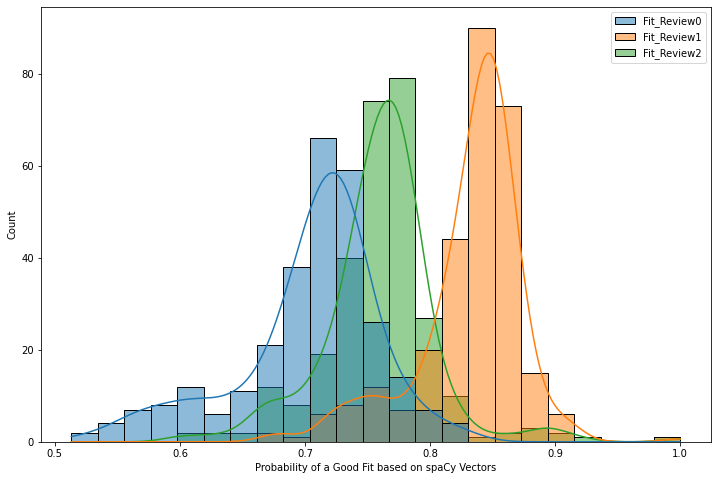

In [458]:
# Sampling from cluster data
num_to_review = 10

# Input 
keywords = input('Input keywords: ')
keywords_processed = word_to_lemma(remove_extraw_t_n(case_punc(expand_contraction(acro_expand(keywords)))))

# Preprocess
keywords_list = [keywords_processed]
# Identify cluster
kw_wv = wordvec_tra.transform(keywords_list)
kw_cluster_w = kmeans_wv.predict(kw_wv)

# Data from cluster
cluster_data_w = final_data.loc[final_data.cluster_wv == kw_cluster_w[0], :].reset_index(drop=True)
X_cl_wv = X_wv[final_data.cluster_wv == kw_cluster_w[0]]
cluster_length = len(X_cl_wv)

# Get nearest neighbors within spaCy cluster according to cosine similarity
ids = get_similarity(X_cl_wv, kw_wv[0], cluster_length)
i_w = np.array(ids).T[0]
d_w = np.array(ids).T[1]
cluster_sample_w = cluster_data_w.iloc[list(i_w)[:num_to_review], :2].copy()
cluster_datafit_w = cluster_data_w.iloc[list(i_w), :2].copy()

# Get 'fit' from cosine distances around keyword
cluster_sample_w['fit'] = d_w[:num_to_review]
cluster_datafit_w['fit'] = d_w

# For recording results for each ranking iteration
iterations_w = cluster_datafit_w.to_numpy()

# Display results
pd.set_option('max_colwidth', 200)
display(cluster_sample_w.iloc[:, 1:])

# Initialize and loop counter
top_choice = cluster_sample_w.index[0]
loop = 0

# Initialize manual review
man_review = True
while man_review:
    
    # Manual review
    inp = input('Enter the index number of the best candidate: ')
         
    # Manual review loop stops when best candidate is at top of list
    if int(inp) == top_choice and loop != 0:
        break       
    
    else:
        
        inpu = int(inp)
        
        # Get nearest neighbors
        ids = get_similarity(X_cl_wv, X_cl_wv[inpu], cluster_length)
        i_w = np.array(ids).T[0]
        d_w = np.array(ids).T[1]
        
        # Enter rows into dataframe using NN indices
        cluster_sample_w = cluster_data_w.iloc[list(i_w)[:num_to_review], :2].copy()
        cluster_datafit_w = cluster_data_w.iloc[list(i_w), :2].copy()
        
        # Rankings based on similarity to starred candidate
        cluster_sample_w['fit'] = d_w[:num_to_review]
        cluster_datafit_w['fit'] = d_w

        # Append new rankings to recorded iterations
        if iterations_w.ndim == 2:
            iterations_w = np.stack((iterations_w, cluster_datafit_w.sort_values(by='fit').to_numpy()), axis=-1)
        else:
            iterations_w = np.concatenate((iterations_w, 
                                         cluster_datafit_w.sort_values(by='fit').to_numpy()
                                         .reshape((cluster_length, 3, 1))), axis=-1)
            
        # Update top choice and loop counter for next iteration
        top_choice = cluster_sample_w.index[0]
        loop += 1
        
        # Display new top num_to_review
        display(cluster_sample_w.iloc[:, 1:])
        
pd.reset_option('max_colwidth')

# Write history of 'fit' into dataframe
search_history_w = pd.DataFrame(iterations_w[:,-1], dtype='float')
search_history_w.columns = [f'Fit_Review{c}' for c in search_history_w.columns]

# Plot histograms from history for neighbors around ideal candidate
print('Distributions of nearest neighbors:')
plt.figure(figsize = (12,8))
g = sns.histplot(search_history_w.iloc[1:, :], kde=True)
g.set(xlabel='Probability of a Good Fit based on spaCy Vectors')
plt.show()